In [ ]:
# import os
# os.environ["XLA_FLAGS"]="--xla_gpu_autotune_level=0"
from foundry.util.runtime import setup
setup()

import jax
import chex
import foundry.core as F
import foundry.numpy as npx
import foundry.random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from matplotlib.cm import ScalarMappable

from foundry.core import tree

from functools import partial
from foundry.core.dataclasses import replace

from policy_eval.common import Result
from policy_eval.methods.diffusion_policy import Checkpoint

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from sklearn.linear_model import LinearRegression


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})

import sklearn.metrics
import wandb

api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/policy-eval/final_result:v59")
checkpoint_ref = list(artifact.files())[-1]._attrs["directUrl"]
checkpoint : Checkpoint = Result.load_s3(checkpoint_ref)

print(jax.devices())

[CudaDevice(id=0)]


In [2]:
def fancy_scatter(ax, x, y, loc=None, log_xscale=False, **kwargs):
    model = LinearRegression()
    if log_xscale: x_reg = npx.log(x)
    else: x_reg = x
    model.fit(x_reg.reshape(-1, 1), y)
    y_pred = model.predict(x_reg.reshape(-1, 1))
    r2 = sklearn.metrics.r2_score(y, y_pred)

    h = ax.scatter(x, y, **kwargs)

    x0, x1 = ax.get_xaxis().get_view_interval()
    if log_xscale: 
        x0 = npx.maximum(x0, 1e-4)
        x0_reg, x1_reg = npx.log(npx.array([x0, x1]))
    else: 
        x0_reg, x1_reg = x0, x1

    y0, y1 = model.predict(((x0_reg,),))[0], model.predict(((x1_reg,),))[0]

    ax.add_line(plt.Line2D((x0, x1), (y0, y1), color="black", linestyle="--", linewidth=1))
    loc = (0.3, 0.3) if loc is None else loc
    ax.text(loc[0], loc[1], f"$r^2 = { r2 : 0.02}$", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    return h


In [3]:
env, splits = checkpoint.data.load({"test", "train"})
train_data = splits["train"].as_pytree()
test_data = splits["test"].as_pytree()
denoiser = checkpoint.create_denoiser()
obs_normalizer = checkpoint.obs_normalizer
act_normalizer = checkpoint.action_normalizer
schedule = checkpoint.schedule

# test_obs = test_data.observations
# test_actions = test_data.actions
# test_obs = train_data.observations
# test_actions = train_data.actions
test_obs = tree.map(lambda x: x[::3], train_data.observations)
test_actions = tree.map(lambda x: x[::3], train_data.actions)
indices = foundry.random.permutation(foundry.random.key(42), tree.axis_size(test_obs))
test_obs = tree.map(lambda x: x[indices], test_obs)
test_actions = tree.map(lambda x: x[indices], test_actions)

In [4]:
# add noise
# test_obs = replace(test_obs, agent_pos=test_obs.agent_pos + 0.1 * foundry.random.normal(foundry.random.key(42), test_obs.agent_pos.shape))

In [5]:
print(tree.shape(test_obs))
print(tree.axis_size(test_obs))

PushTPosObs(agent_pos=(6171, 1, 2), block_pos=(6171, 1, 2), block_rot=(6171, 1))
6171


In [6]:
@jax.jit
def measure_ddim_ddpm_ot(batch_rng_key, obs_batch, noise=None):
    def measure_diff(input):
        rng_key, obs = input
        rng_key, n_rng_key = jax.random.split(rng_key)
        if noise is not None:
            obs_flat, uf = tree.ravel_pytree(obs)
            obs_flat = obs_flat + noise * jax.random.normal(n_rng_key, obs_flat.shape)
            obs = uf(obs_flat)

        def do_sample(rng_key, eta=1.0):
            obs_normalized = obs_normalizer.normalize(obs)
            action = schedule.sample(rng_key, partial(denoiser, obs_normalized), 
                                     act_normalizer.structure, eta=eta)
            return action
        do_sample = jax.vmap(do_sample, in_axes=(0, None))

        ddim_rng, ddpm_rng = jax.random.split(rng_key)
        ddpm_samples = do_sample(jax.random.split(ddpm_rng, 32), 0.0)
        ddim_samples = do_sample(jax.random.split(ddim_rng, 32), 1.0)

        chex.assert_trees_all_equal_shapes_and_dtypes(ddpm_samples, ddim_samples)
        ddpm_flat = jax.vmap(lambda x: tree.ravel_pytree(x)[0])(ddpm_samples)
        ddim_flat = jax.vmap(lambda x: tree.ravel_pytree(x)[0])(ddim_samples)

        geom = pointcloud.PointCloud(
                ddpm_flat, ddim_flat, epsilon=0.005
        )
        prob = linear_problem.LinearProblem(geom)
        solver = sinkhorn.Sinkhorn(max_iterations=8_000)
        out = solver(prob)
        return out.converged, out.primal_cost
    return jax.lax.map(measure_diff,
        (foundry.random.split(batch_rng_key, tree.axis_size(obs_batch)), obs_batch),
        batch_size=128
    )
    # return jax.vmap(lambda rng_key, obs: measure_diff((rng_key, obs)), in_axes=((None, 0)))(batch_rng_key, obs_batch)


In [7]:
converged, test_ddpm_ot = measure_ddim_ddpm_ot(foundry.random.key(42), test_obs)


In [8]:
@jax.jit
def measure_schedule_inconsistency(batch_rng_key, obs_batch):
    def measure_si(inputs):
        rng_key, obs = inputs
        def t_si(rng_key, t):
            def do_sample(rng_key, eta=1.0):
                obs_normalized = obs_normalizer.normalize(obs)
                action = schedule.sample(rng_key, partial(denoiser, obs_normalized), 
                                            act_normalizer.structure, eta=eta)
                action_noised, _, _ = schedule.add_noise(rng_key, action, t)
                return action, action_noised
            do_sample = jax.vmap(do_sample, in_axes=(0, None))
            rng_key, s_rng = jax.random.split(rng_key, 2)
            ddpm_samples, noised_samples = do_sample(jax.random.split(s_rng, 128), 0.0)

            def nw_output(x):
                return schedule.output_from_denoised(x, t, schedule.compute_denoised(x, t, ddpm_samples))
            nw = jax.vmap(nw_output)(noised_samples)
            ddpm = jax.vmap(lambda x: denoiser(obs, None, x, t))(noised_samples)
            return npx.linalg.norm(nw - ddpm)
        sis = jax.vmap(t_si)(foundry.random.split(rng_key, schedule.num_steps // 2), npx.arange(1, schedule.num_steps + 1, 2))
        return npx.mean(sis)
    return jax.lax.map(measure_si,
        (foundry.random.split(batch_rng_key, tree.axis_size(obs_batch)), obs_batch),
        batch_size=128
    )


In [9]:
test_si = measure_schedule_inconsistency(foundry.random.key(42), test_obs)


2025-01-29 13:15:32.736399: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 15.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [10]:
@jax.jit
def measure_variance(rng_key, obs):
    def measure_var(inputs):
        rng_key, obs = inputs
        def do_sample(rng_key, eta=1.0):
            obs_normalized = obs_normalizer.normalize(obs)
            action = schedule.sample(rng_key, partial(denoiser, obs_normalized), 
                                        act_normalizer.structure, eta=eta)
            return action
        do_sample = jax.vmap(do_sample, in_axes=(0, None))
        rng_key, s_rng = jax.random.split(rng_key, 2)
        ddpm_samples = do_sample(jax.random.split(s_rng, 128), 0.0)
        ddpm_samples = ddpm_samples.reshape((ddpm_samples.shape[0], -1))
        ddpm_samples = ddpm_samples - npx.mean(ddpm_samples, axis=0)[None, :]
        ddpm_samples = npx.mean(npx.sum(npx.square(ddpm_samples), axis=-1))
        return ddpm_samples
    return jax.lax.map(
        measure_var, (jax.random.split(rng_key, tree.axis_size(obs)), obs), batch_size=128
    )


In [11]:
test_var = measure_variance(foundry.random.key(42), test_obs)


In [12]:
print(converged.shape[0] - npx.sum(converged), test_ddpm_ot)

2 [0.00355434 0.00487859 0.00395995 ... 0.00419531 0.00319707 0.00966399]


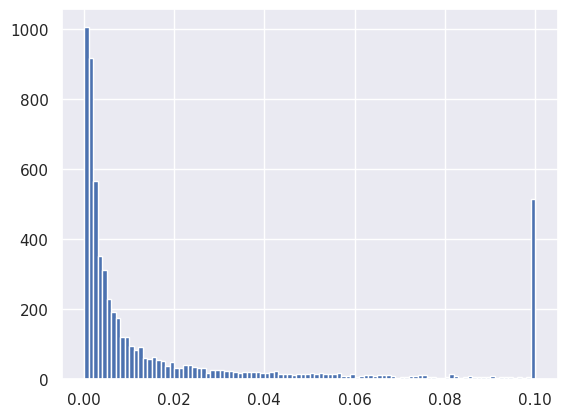

In [13]:
plt.hist(test_var.clip(0, 0.1), bins=100)
plt.show()

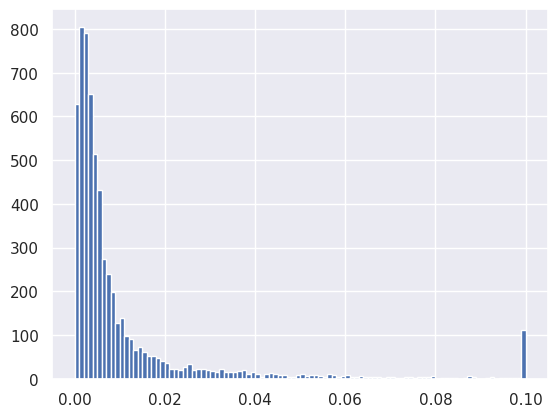

In [14]:
plt.hist(test_ddpm_ot[converged].clip(0,0.1), bins=100)
plt.show()


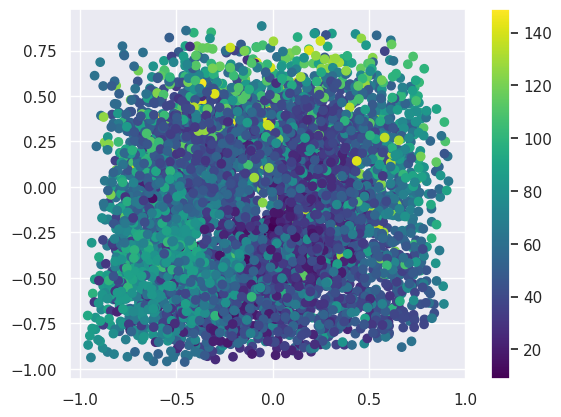

In [15]:
plt.scatter(test_obs.agent_pos[:, :, 0], test_obs.agent_pos[:, :, 1], c=test_si, cmap="viridis")
plt.colorbar()

In [30]:
def scale(obs):
    return replace(obs,
        agent_pos=obs.agent_pos / 0.7,
        block_pos=obs.block_pos / 1.5,
        block_rot=obs.block_rot / 1.5,
    )

def obs_density(obs):
    def dist(other):
        chex.assert_trees_all_equal_shapes_and_dtypes(obs, other)
        obs_normalized = obs_normalizer.normalize(obs)
        other_normalized = obs_normalizer.normalize(other)
        obs_normalized = scale(obs_normalized)
        other_normalized = scale(other_normalized)
        # obs_normalized = obs_normalized.agent_pos
        # other_normalized = other_normalized.agent_pos
        obs_flat, _ = tree.ravel_pytree(obs_normalized)
        other_flat, _ = tree.ravel_pytree(other_normalized)
        return npx.sum(npx.square(obs_flat - other_flat))
    dists = jax.vmap(dist)(tree.map(lambda x: x[::3], train_data.observations))
    log_probs = -dists / 2
    log_prob = jax.scipy.special.logsumexp(log_probs) - npx.log(dists.shape[0])
    return log_prob

test_densities = jax.vmap(obs_density)(test_obs)
# test_densities = test_densities - jax.scipy.special.logsumexp(test_densities)
test_densities = npx.exp(test_densities)
test_densities = test_densities / npx.max(test_densities)


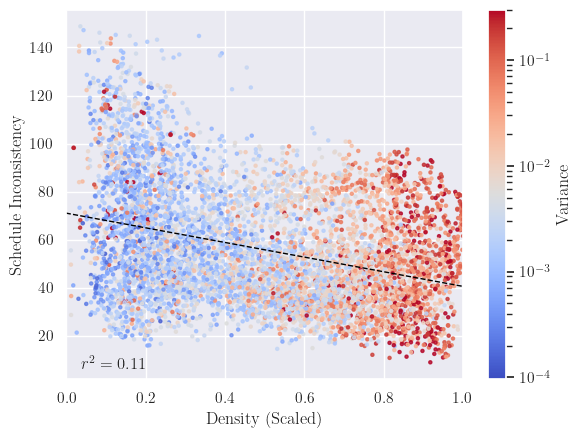

In [118]:
import matplotlib

def density_vs_si(fig, ax, colorbar=True):
    h = fancy_scatter(ax, test_densities, test_si, alpha=0.8, 
                s=5, c=test_var.clip(0., 0.3), cmap="coolwarm",
                loc=(0.12, 0.04), norm=matplotlib.colors.LogNorm())
    ax.set_xlabel("Density (Scaled)")
    ax.set_ylabel("Schedule Inconsistency")
    if colorbar:
        cbar = fig.colorbar(
            ScalarMappable(cmap=h.get_cmap(), norm=h.norm), ax=ax,
            label="Variance"
        )
    ax.set_xlim(0, 1.0)
fig, ax = plt.subplots()
density_vs_si(fig, ax)
fig.show()


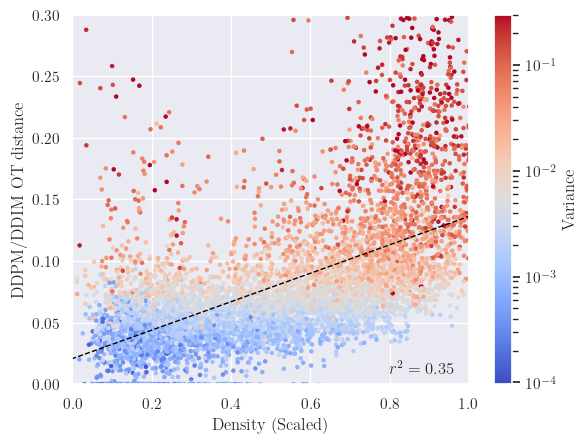

In [119]:
def density_vs_ot(fig, ax, colorbar=True):
    mask = (test_ddpm_ot < 0.09)
    h = fancy_scatter(ax, test_densities[converged & mask], npx.sqrt(test_ddpm_ot[converged & mask].clip(0, None)), loc=(0.88, 0.04), s=5,
                c=test_var[converged & mask].clip(0., 0.3), cmap="coolwarm", norm=matplotlib.colors.LogNorm())
    ax.set_ylim(0., 0.3)
    ax.set_xlim(0, 1.0)
    ax.set_ylabel("DDPM/DDIM OT distance")
    ax.set_xlabel("Density (Scaled)")
    if colorbar:
        fig.colorbar(h, label="Variance", ax=ax)
    return h
fig, ax = plt.subplots()
density_vs_ot(fig, ax)
plt.show()

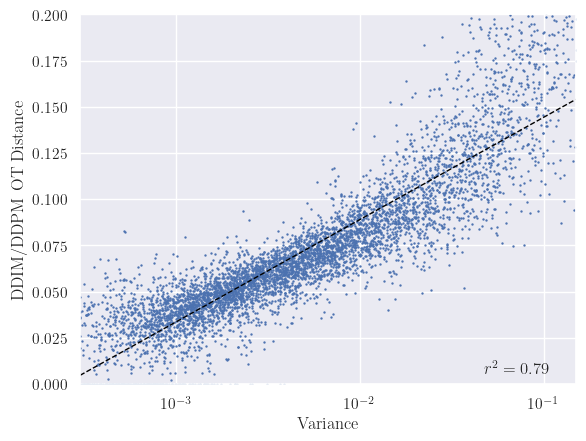

In [120]:
def var_vs_ot(fig, ax):
    mask = (test_var < 0.2) & (test_ddpm_ot < 0.05)
    ax.set_xlim(3e-4, 0.15)
    ax.set_ylim(0, 0.2)
    h = fancy_scatter(ax, test_var[mask], npx.sqrt(test_ddpm_ot[mask].clip(0, None)), s=0.5, loc=(0.88, 0.04), log_xscale=True)
                #   c=test_si[mask], cmap="coolwarm")
    # plt.colorbar(h)
    ax.set_xscale("log")
    ax.set_ylabel("DDIM/DDPM OT Distance")
    ax.set_xlabel("Variance")
fig, ax = plt.subplots()
var_vs_ot(fig, ax)
plt.show()

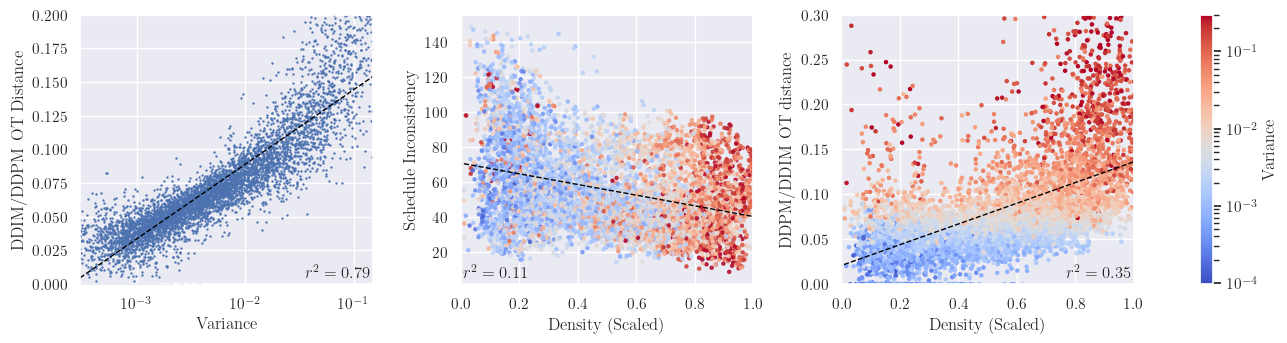

In [122]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 3.5))
var_vs_ot(fig, ax1)
density_vs_si(fig, ax2, colorbar=False)
h = density_vs_ot(fig, ax3, colorbar=False)
fig.subplots_adjust(wspace=0.3)
fig.colorbar(h, label="Variance", ax=[ax1, ax2, ax3])
fig.savefig("diffusion_policy_combined_horiz.pdf", bbox_inches="tight")
fig.show()


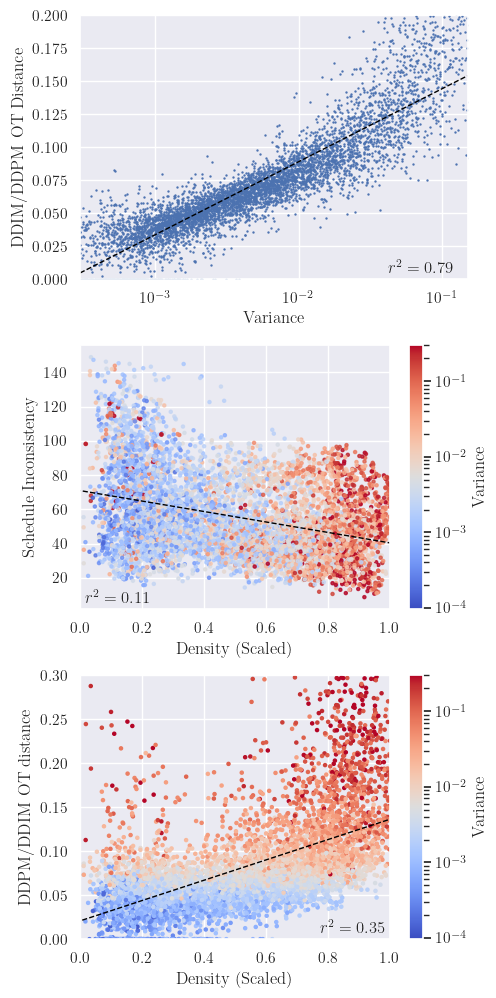

In [123]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 12))
var_vs_ot(fig, ax1)
density_vs_si(fig, ax2)
density_vs_ot(fig, ax3)
fig.subplots_adjust(hspace=0.25)
fig.savefig("diffusion_policy_combined_vert.pdf", bbox_inches="tight")
fig.show()

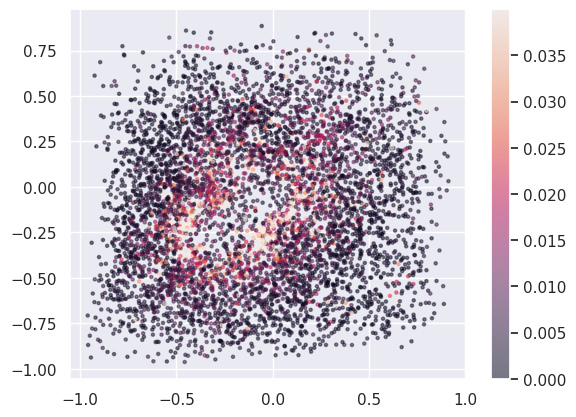

In [21]:
plt.scatter(test_obs.agent_pos[:,:, 0], test_obs.agent_pos[:,:, 1], c=test_ddpm_ot.clip(0,0.04), s=5, alpha=0.5)
plt.colorbar()

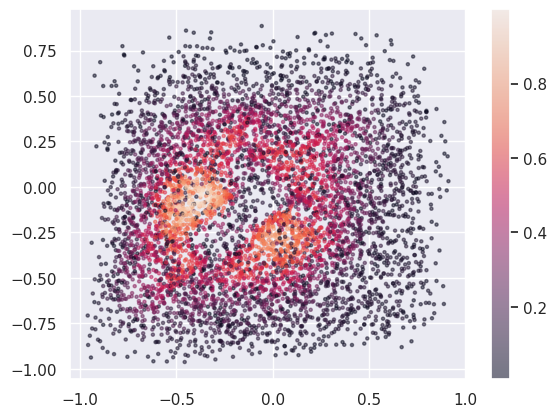

In [20]:
plt.scatter(test_obs.agent_pos[:,:, 0], test_obs.agent_pos[:,:, 1], c=test_densities, s=5, alpha=0.5)
plt.colorbar()